# Exploratory Data Analysis-BioRxiv

This notebook is designed to generate descriptive statistics for a snapshot of the BioRxiv repository. The following information is obtained: 
1. if the article is a research article
2. if the article is a new, contradictory, or confirmatory analysis
3. the category assigned to each research article (pi self assigns)
4. the type of section headers contain in each research article

## Load the environment to parse BioRxiv

In [1]:
from pathlib import Path
import re
from itertools import product

import lxml.etree as ET
import pandas as pd
import plotnine as p9
from tqdm import tqdm_notebook

In [2]:
biorxiv_files = Path("../biorxiv_articles").rglob("*.xml")

## Parse BioRxiv

In [3]:
def header_group_mapper(header):
    if re.search("method", header, flags=re.I):
        return "material and methods"
    if re.search("abstract", header, flags=re.I):
        return "abstract"
    if re.search("conclusion", header, flags=re.I):
        return "conclusion"
    if re.search(r"(supplementary|supplemental) material", header, flags=re.I):
        return "supplemental material"
    if re.search(r"(declaration[s]?( of interest[s]?)?)|(competing (financial )?interest[s]?)", header, flags=re.I):
        return "conflict of interest"
    if re.search("additional information", header, flags=re.I):
        return "supplemental information"
    if re.search(r"author[s]?[']? contribution[s]?", header, flags=re.I):
        return "author contribution"
    if re.search(r"(supplementary|supporting) information", header, flags=re.I):
        return "supplemental information"
    if re.search("data accessibility", header, flags=re.I):
        return "data availability"
    if re.search(r"experimental procedures", header, flags=re.I):
        return "material and methods"
    return header

In [4]:
article_metadata = []
article_sections = []

type_mapper = {
    'author-type':'author_type',
    'heading':'heading',
    'hwp-journal-coll':'category'
}
xml_parser = ET.XMLParser(encoding='UTF-8', recover=True)
for file in tqdm_notebook(biorxiv_files):
    article = file.with_suffix('').name
    root = ET.parse(open(file, "rb"), parser=xml_parser).getroot()
    
    # Grab the subject category
    metadata = {
        type_mapper[x.attrib['subj-group-type']]:x.getchildren()[0].text.lower()
        for x in root.xpath('//subj-group')
    }
    
    metadata.update({'document':f"{article}.xml", 'doi':root.xpath('//article-id')[0].text})
    article_metadata.append(metadata)
    
    # Grab the section titles 
    section_objs = list(
        filter(
            lambda x: "id" in x.attrib and re.search(r"s[\d]+$", x.attrib['id']) is not None,
            root.xpath('//sec')
        )
    )
    
    title_objs = list(map(lambda x: x.xpath('title//text()'), section_objs))
    title_objs = list(filter(lambda x: len(x) > 0, title_objs))
    
    # edge case in the xml where
    # a tag contains the following: <title>A<sc>bstract</sc></title>
    # why is there a <sc> tag?
    if any(list(map(lambda x: len(x) > 1, title_objs))):
    
        # filter out weird characters ⓘ
        # cant think of a better way to handle these types of edge cases
        title_objs = list(map(lambda headers: list(filter(lambda token: token != 'ⓘ', headers)), title_objs))
        title_objs = list(map(lambda x: x[0] + x[1] if len(x) > 1 else x, title_objs))
    
    abstract_section = root.xpath('//abstract/title//text()')
    if len(abstract_section) > 0:
        
        # in case of a parse error that splits A from bstract
        if len(abstract_section) > 1:
            abstract_section = ["".join(abstract_section)]
        
        title_objs = title_objs + [abstract_section]

    title_objs = list(map(lambda x: x[0].rstrip().lower(), title_objs))
    
    article_sections += list(
        map(
            lambda x: {'section':header_group_mapper(x[0]), 'document':x[1]},
            product(title_objs, [article])
        )
    )

In [5]:
metadata_df = (
    pd.DataFrame
    .from_records(article_metadata)
    .fillna({"category":'none', 'author_type':'none', 'heading':'none'})
    .assign(category=lambda x:x.category.apply(lambda x: " ".join(x.split("_")) if "_" in x else x))
    .replace(
        {'heading':
              {
                "bioinformatics":"none",
                "genomics": "none",
                "zoology": "none",
                "evolutionary biology": "none",
                "animal behavior and cognition": "none",
                "ecology":"none",
                "genetics":"none"
              }
        }
    )
)

metadata_df.to_csv("output/biorxiv_article_metadata.tsv", sep="\t", index=False)
metadata_df.head()

,author_type,heading,category,document,doi
0,regular article,new results,genetics,440735_v1.xml,10.1101/440735
1,regular article,new results,systems biology,775270_v1.xml,10.1101/775270
2,regular article,new results,genetics,242404_v1.xml,10.1101/242404
3,regular article,new results,neuroscience,872994_v1.xml,10.1101/2019.12.11.872994
4,regular article,new results,developmental biology,080853_v2.xml,10.1101/080853


In [6]:
sections_df = (
    pd.DataFrame
    .from_records(article_sections)
)

sections_df.to_csv("output/biorxiv_article_sections.tsv", sep="\t", index=False)
sections_df.head()

,section,document
0,research in context,440735_v1
1,introduction,440735_v1
2,results,440735_v1
3,discussion,440735_v1
4,material and methods,440735_v1


# Regular Research Articles?

BioRxiv claims that each article should be a research article. The plot below mainly confirms that statement.

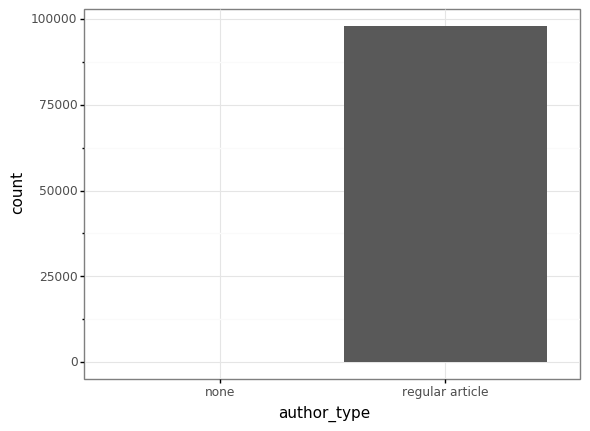

<ggplot: (-9223363282468561583)>


In [7]:
g = (
    p9.ggplot(metadata_df, p9.aes(x="author_type"))
    + p9.geom_bar(size=10)
    + p9.theme_bw()
)
print(g)

In [8]:
metadata_df["author_type"].value_counts()

regular article    98014
none                   9
Name: author_type, dtype: int64

# BioRxiv Research Article Categories

Categories assigned to each research article. Neuroscience dominates majority of the articles as expected.

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/preprint_category.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


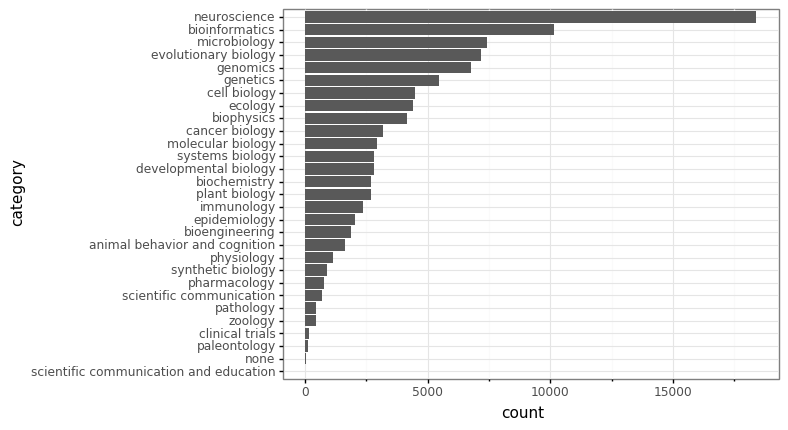

<ggplot: (8754393592822)>


In [9]:
category_list = metadata_df.category.value_counts().index.tolist()[::-1]

# plot nine doesn't implement reverse keyword for scale x discrete
# ugh...
g = (
    p9.ggplot(metadata_df, p9.aes(x="category"))
    + p9.geom_bar(size=10)
    + p9.scale_x_discrete(limits=category_list)
    + p9.coord_flip()
    + p9.theme_bw()
)
g.save("output/figures/preprint_category.png", dpi=500)
print(g)

In [10]:
metadata_df["category"].value_counts()

neuroscience                              18390
bioinformatics                            10152
microbiology                               7407
evolutionary biology                       7174
genomics                                   6759
genetics                                   5443
cell biology                               4480
ecology                                    4386
biophysics                                 4145
cancer biology                             3176
molecular biology                          2947
systems biology                            2821
developmental biology                      2797
biochemistry                               2689
plant biology                              2672
immunology                                 2351
epidemiology                               2038
bioengineering                             1882
animal behavior and cognition              1632
physiology                                 1139
synthetic biology                       

# New, Confirmatory, Contradictory Results?

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/preprint_headings.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


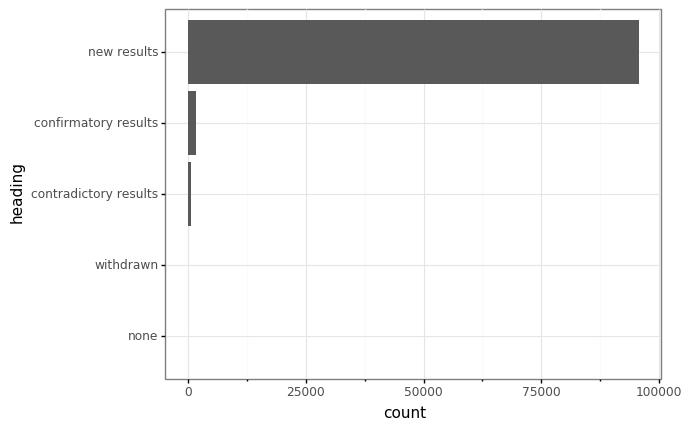

<ggplot: (-9223363282474049676)>


In [11]:
heading_list = metadata_df.heading.value_counts().index.tolist()[::-1]

g = (
    p9.ggplot(
        metadata_df, 
        p9.aes(x="heading")
    )
    + p9.geom_bar(size=10)
    + p9.scale_x_discrete(limits=heading_list)
    + p9.coord_flip()
    + p9.theme_bw()
)
g.save("output/figures/preprint_headings.png", dpi=500)
print(g)

In [12]:
metadata_df["heading"].value_counts()

new results              95585
confirmatory results      1668
contradictory results      671
withdrawn                   72
none                        27
Name: heading, dtype: int64

# BioRxiv Section Articles

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/preprint_sections.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


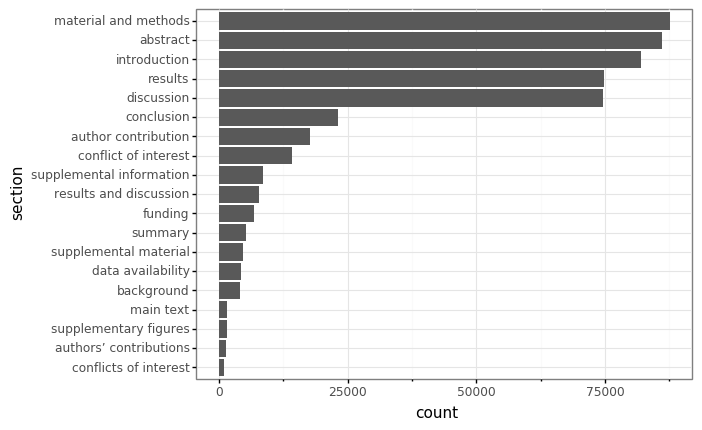

<ggplot: (8754387660285)>


In [13]:
section_list = sections_df.section.value_counts()
section_list = section_list[section_list > 800].index.to_list()[::-1]

g = (
    p9.ggplot(sections_df[sections_df.section.isin(section_list)])
    + p9.aes(x="section")
    + p9.geom_bar(position="dodge")
    + p9.scale_x_discrete(limits=section_list)
    + p9.coord_flip()
    + p9.theme_bw()
)
g.save("output/figures/preprint_sections.png", dpi=500)
print(g)

In [14]:
section_list = sections_df.section.value_counts()
section_list[section_list > 800]

material and methods        87638
abstract                    86150
introduction                82045
results                     74852
discussion                  74564
conclusion                  23179
author contribution         17698
conflict of interest        14123
supplemental information     8635
results and discussion       7726
funding                      6792
summary                      5319
supplemental material        4713
data availability            4340
background                   3983
main text                    1473
supplementary figures        1469
authors’ contributions       1385
conflicts of interest         928
Name: section, dtype: int64